# Results: CodeIt vs mutation baseline vs ablations

In [1]:
import pandas as pd
import json
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from run.run_codeit import calculate_performance_over_inference_tasks

/home/wzhu/anaconda3/envs/new_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def thousand_formatter(x, pos):
    return '{}k'.format(int(x*1e-3))

In [3]:
def get_mutation_performance(experiment_dir):
    performance = pd.read_csv(f'{experiment_dir}mutation_performance.csv',header=None).set_axis(['num_samples', 'performance'], axis=1)
    return performance.to_dict()

In [4]:
def get_codeit_performance(experiment_dir):
    return pd.read_csv(f"{experiment_dir}/performance.csv").to_dict()

In [5]:
def transform_solutions(old_solutions):
    new_solutions = {}
    for task_key, solutions in old_solutions['policy']['seen_example'].items():
        for solution in solutions.values():
            program = solution['program']
            if task_key in new_solutions:
                new_solutions[task_key][program] = solution
            else:
                new_solutions[task_key]={program: solution}
    return new_solutions

In [6]:
def combine_solutions(policy_solutions, mutation_solutions):
    combined_solutions = copy.copy(policy_solutions)
    for task_key in mutation_solutions:
        for program in mutation_solutions[task_key]:
            if task_key in combined_solutions:
                combined_solutions[task_key][program] = mutation_solutions[task_key][program]
            else:
                combined_solutions[task_key] = {program: mutation_solutions[task_key][program]}
    return combined_solutions

In [7]:
def get_mutation_solutions(experiment_dir, num_mutated):
    with open(f'{experiment_dir}mutation_solutions_{num_mutated}.json','r') as f:
        solutions = json.load(f)
    return solutions

In [8]:
def get_codeit_cumulative_performance(experiment_dir, inference_keys, mutation_solutions=None):
    solution_files = [f"{solution_file}" for solution_file in os.listdir(experiment_dir) if solution_file.startswith('solutions')]
    cumulative_performance_per_meta_iteration = {}
    for i in range(1,101):
        if f"solutions_{i}.json" in solution_files:
            with open(f"{experiment_dir}/solutions_{i}.json",'r') as f:
                policy_solutions=transform_solutions(json.load(f))
            if mutation_solutions:
                codeit_solutions = combine_solutions(policy_solutions, mutation_solutions)
            else:
                codeit_solutions = policy_solutions
            cumulative_performance = np.mean(calculate_performance_over_inference_tasks(codeit_solutions, inference_keys=inference_keys)['test_performance'])
            cumulative_performance_per_meta_iteration[i] = cumulative_performance
    return cumulative_performance_per_meta_iteration

In [22]:
def get_codeit_cumulative_performance(experiment_dir, inference_keys, mutation_solutions=None):
    solution_files = [f"{solution_file}" for solution_file in os.listdir(experiment_dir) if solution_file.startswith('solutions')]
    cumulative_performance_per_meta_iteration = {}
    mutation_solutions = None
    for i in range(1,101):
        if f"solutions_{i}.json" in solution_files:
            with open(f"{experiment_dir}/solutions_{i}.json",'r') as f:
                policy_solutions=transform_solutions(json.load(f))
            if mutation_solutions:
                codeit_solutions = combine_solutions(policy_solutions, mutation_solutions)
            else:
                codeit_solutions = policy_solutions
            cumulative_performance = np.mean(calculate_performance_over_inference_tasks(codeit_solutions, inference_keys=inference_keys)['test_performance'])
            cumulative_performance_per_meta_iteration[i] = cumulative_performance
    return cumulative_performance_per_meta_iteration

## 1. Load data

In [9]:
SPLIT_KEY_PATH = 'data/split_keys.json'
CODEIT_PATHS = {'codeit':'outputs/codeit/',
                'a1_no_exit': 'outputs/a1_no_exit/',
                'a2_no_relabeling': 'outputs/a2_no_relabeling/',
                'a3_no_priority': 'outputs/a3_no_priority/',
                'a4_no_pretraining': 'outputs/a4_no_pretraining/',
                'a5_one_demo_example': 'outputs/a5_one_demo_example/',
                'a6_no_mutation': 'outputs/a6_no_mutation/',
               }
MUTATION_PATH = 'data/'
NUM_MUTATED = 19_200
SAMPLES_PER_META_ITERATION = 24 * 400

In [9]:
SPLIT_KEY_PATH = 'data/split_keys.json'
CODEIT_PATHS = {'original mutation':'outputs/codeit/',
                'preli_mutate': 'outputs/codeit_preli/',
                'adv_mutate': 'outputs/codeit_adv/',
                'preli+adv': 'outputs/codeit_preli_adv/',
                'preli+adv 2': 'outputs/codeit_preli_adv_2/',
                'adv_mutate 2': 'outputs/codeit_adv_2/',
                'generator': 'outputs/codeit_plus_generator/',
                'preli+adv+complement': 'outputs/codeit_preli_adv_complement/',
                'preli+adv+complement+generator': 'outputs/codeit_preli_adv_complement_generator/',
                # 'a6_no_mutation': 'outputs/a6_no_mutation/',
               }
MUTATION_PATH = 'data/'
NUM_MUTATED = 19_200
SAMPLES_PER_META_ITERATION = 24 * 400

In [51]:
SPLIT_KEY_PATH = 'data/split_keys.json'
CODEIT_PATHS = {'original mutation':'outputs/codeit_Julian/',
                'preli_mutate': 'outputs/codeit_Julian_preli/',
                'adv_mutate': 'outputs/codeit_Julian_adv/',
                'preli+adv': 'outputs/codeit_Julian_preli_adv/',
                'preli+adv 2': 'outputs/codeit_Julian_preli_adv_2/',
                'adv_mutate 2': 'outputs/codeit_Julian_adv_2/',
                'generator': 'outputs/codeit_Julian_generator/',
                'preli+adv+complement': 'outputs/codeit_Julian_preli_adv_complement/',
                'preli+adv+complement+generator': 'outputs/codeit_Julian_preli_adv_complement_generator/',
                'without DSL pre-training': 'outputs/codeit_t5small/',

                # 'a6_no_mutation': 'outputs/a6_no_mutation/',
               }
MUTATION_PATH = 'data/'
NUM_MUTATED = 19_200
SAMPLES_PER_META_ITERATION = 24 * 400

In [54]:
with open(SPLIT_KEY_PATH, 'r') as f:
    eval_keys = json.load(f)['test']

In [55]:
mutation_solutions = get_mutation_solutions(experiment_dir=MUTATION_PATH, num_mutated=NUM_MUTATED)
mutation_performance = get_mutation_performance(experiment_dir=MUTATION_PATH)

In [56]:
codeit_policy_performance = {experiment_name: get_codeit_performance(experiment_dir=CODEIT_PATHS[experiment_name])['performance'].values() for experiment_name in CODEIT_PATHS}
codeit_cumulative_performance = {experiment_name: get_codeit_cumulative_performance(experiment_dir=CODEIT_PATHS[experiment_name],inference_keys=eval_keys, mutation_solutions=None) if 'no_mutation' in experiment_name else get_codeit_cumulative_performance(experiment_dir=CODEIT_PATHS[experiment_name],inference_keys=eval_keys, mutation_solutions=mutation_solutions) for experiment_name in CODEIT_PATHS}

## 2. Plot results

### CodeIt vs mutation baseline (cumulative performance)

In [16]:
formatter = FuncFormatter(thousand_formatter)
num_samples = range(NUM_MUTATED+SAMPLES_PER_META_ITERATION, NUM_MUTATED+SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_cumulative_performance['codeit'])), SAMPLES_PER_META_ITERATION)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))
plt.plot(num_samples, codeit_cumulative_performance['codeit'].values(), label='CodeIt')
plt.plot(mutation_performance['num_samples'].values(), mutation_performance['performance'].values(), label='Mutation $d_1$ Baseline', color='black', linestyle='-')
plt.legend()
plt.ylabel('Fraction of tasks solved')
plt.xlabel('Number of sampled programs')
plt.xlim(0,1_000_000)
plt.ylim(0,0.17)
ax.grid(True)
plt.show()

KeyError: 'codeit'

### CodeIt vs ablations (cumulative performance)

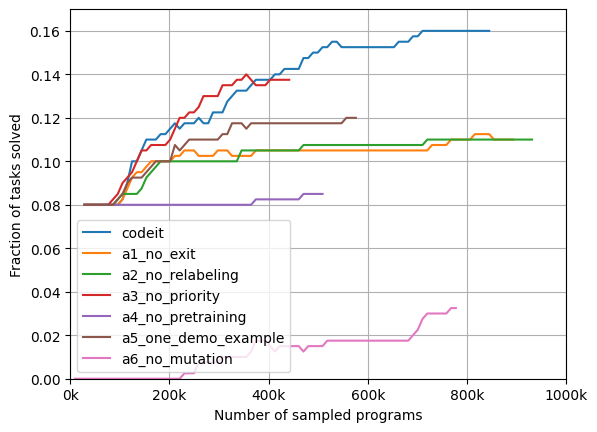

In [14]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))
for experiment_name in codeit_policy_performance:
    if experiment_name == 'a6_no_mutation':
        num_samples = range(SAMPLES_PER_META_ITERATION, SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_cumulative_performance[experiment_name])), SAMPLES_PER_META_ITERATION)     
    else:
        num_samples = range(NUM_MUTATED+SAMPLES_PER_META_ITERATION, NUM_MUTATED+SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_cumulative_performance[experiment_name])), SAMPLES_PER_META_ITERATION)
    plt.plot(num_samples, codeit_cumulative_performance[experiment_name].values(), label=experiment_name)
plt.legend()
plt.ylabel('Fraction of tasks solved')
plt.xlabel('Number of sampled programs')
plt.xlim(0,1_000_000)
plt.ylim(0,0.17)
ax.grid(True)
plt.show()

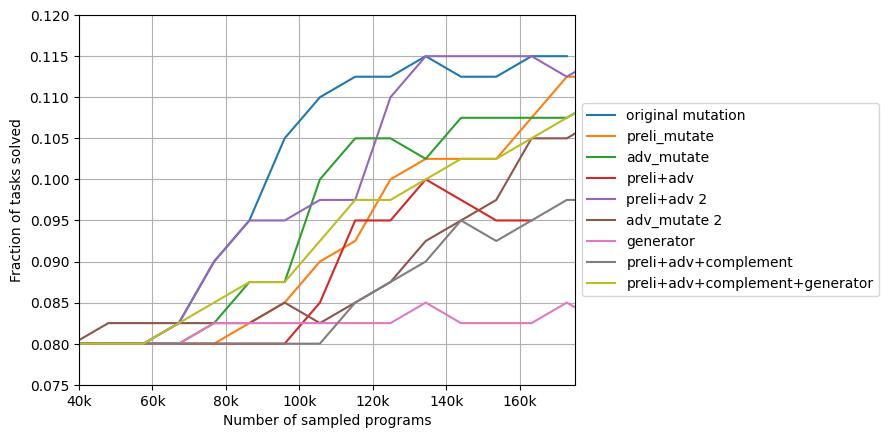

In [14]:
formatter = FuncFormatter(thousand_formatter)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))
for experiment_name in codeit_policy_performance:
    if experiment_name == 'a6_no_mutation':
        num_samples = range(SAMPLES_PER_META_ITERATION, SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_cumulative_performance[experiment_name])), SAMPLES_PER_META_ITERATION)     
    else:
        num_samples = range(NUM_MUTATED+SAMPLES_PER_META_ITERATION, NUM_MUTATED+SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_cumulative_performance[experiment_name])), SAMPLES_PER_META_ITERATION)
    plt.plot(num_samples, codeit_cumulative_performance[experiment_name].values(), label=experiment_name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Fraction of tasks solved')
plt.xlabel('Number of sampled programs')
plt.xlim(40_000,175_000)
plt.ylim(0.075,0.12)
ax.grid(True)
plt.show()

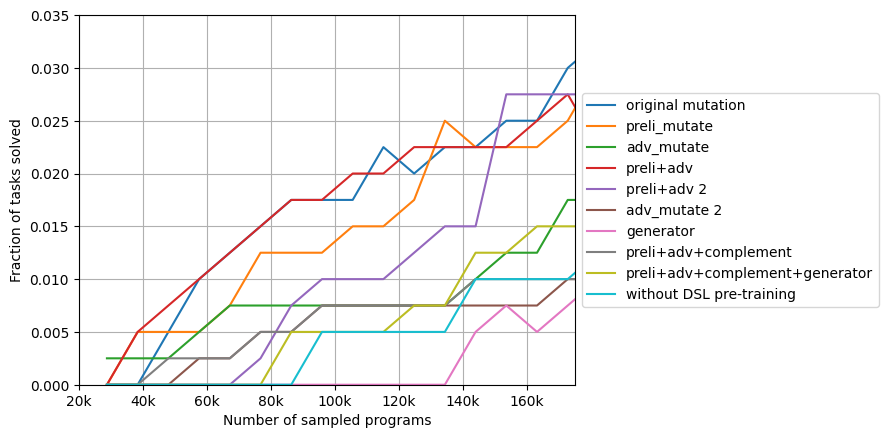

In [57]:
formatter = FuncFormatter(thousand_formatter)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))
for experiment_name in codeit_policy_performance:
    if experiment_name == 'a6_no_mutation':
        num_samples = range(SAMPLES_PER_META_ITERATION, SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_cumulative_performance[experiment_name])), SAMPLES_PER_META_ITERATION)     
    else:
        num_samples = range(NUM_MUTATED+SAMPLES_PER_META_ITERATION, NUM_MUTATED+SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_cumulative_performance[experiment_name])), SAMPLES_PER_META_ITERATION)
    plt.plot(num_samples, codeit_cumulative_performance[experiment_name].values(), label=experiment_name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Fraction of tasks solved')
plt.xlabel('Number of sampled programs')
plt.xlim(20_000,175_000)
plt.ylim(0,0.035)
ax.grid(True)
plt.show()

### CodeIt vs ablations (policy-only performance)

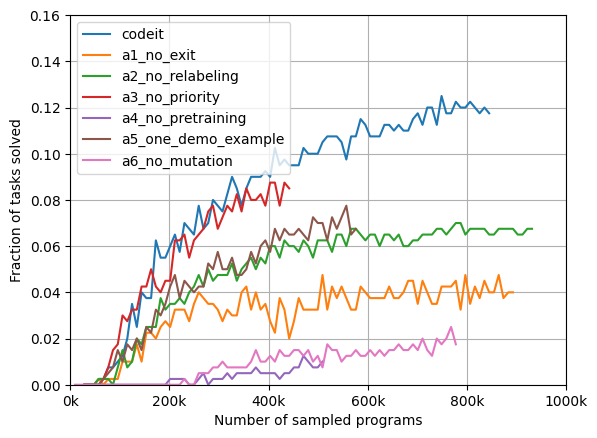

In [15]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))
for experiment_name in codeit_policy_performance:
    if experiment_name == 'a6_no_mutation':
        num_samples = range(SAMPLES_PER_META_ITERATION, SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_policy_performance[experiment_name])), SAMPLES_PER_META_ITERATION)     
    else:
        num_samples = range(NUM_MUTATED+SAMPLES_PER_META_ITERATION, NUM_MUTATED+SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_policy_performance[experiment_name])), SAMPLES_PER_META_ITERATION)
    plt.plot(num_samples, codeit_policy_performance[experiment_name], label=experiment_name)
plt.legend()
plt.ylabel('Fraction of tasks solved')
plt.xlabel('Number of sampled programs')
plt.xlim(0,1_000_000)
plt.ylim(0,0.16)
ax.grid(True)
plt.show()

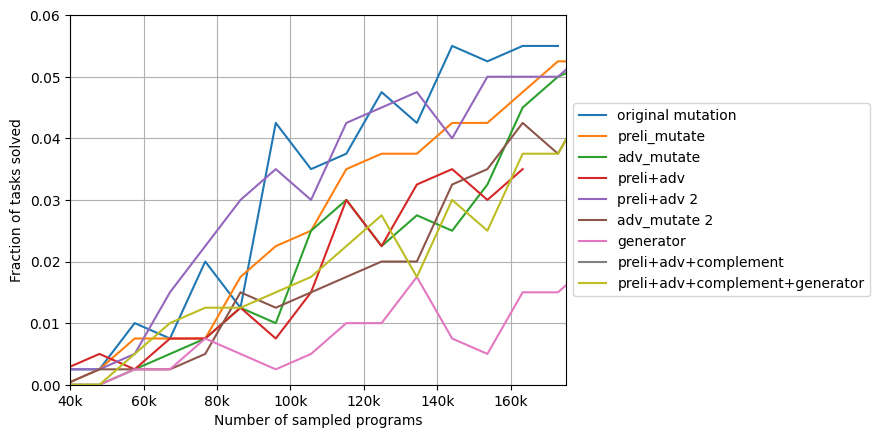

In [15]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))
for experiment_name in codeit_policy_performance:
    if experiment_name == 'a6_no_mutation':
        num_samples = range(SAMPLES_PER_META_ITERATION, SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_policy_performance[experiment_name])), SAMPLES_PER_META_ITERATION)     
    else:
        num_samples = range(NUM_MUTATED+SAMPLES_PER_META_ITERATION, NUM_MUTATED+SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_policy_performance[experiment_name])), SAMPLES_PER_META_ITERATION)
    plt.plot(num_samples, codeit_policy_performance[experiment_name], label=experiment_name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Fraction of tasks solved')
plt.xlabel('Number of sampled programs')
plt.xlim(40_000,175_000)
plt.ylim(0,0.06)
ax.grid(True)
plt.show()

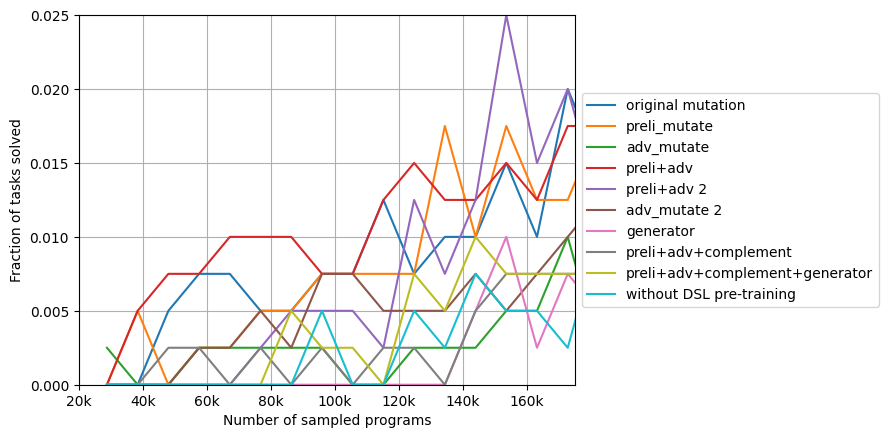

In [58]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(plt.FuncFormatter(formatter))
for experiment_name in codeit_policy_performance:
    if experiment_name == 'a6_no_mutation':
        num_samples = range(SAMPLES_PER_META_ITERATION, SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_policy_performance[experiment_name])), SAMPLES_PER_META_ITERATION)     
    else:
        num_samples = range(NUM_MUTATED+SAMPLES_PER_META_ITERATION, NUM_MUTATED+SAMPLES_PER_META_ITERATION + (SAMPLES_PER_META_ITERATION*len(codeit_policy_performance[experiment_name])), SAMPLES_PER_META_ITERATION)
    plt.plot(num_samples, codeit_policy_performance[experiment_name], label=experiment_name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Fraction of tasks solved')
plt.xlabel('Number of sampled programs')
plt.xlim(20_000,175_000)
plt.ylim(0,0.025)
ax.grid(True)
plt.show()